<a href="https://colab.research.google.com/github/xuqibai/Delfine-SARIMA/blob/main/Wind_Rothenborn_2018_2020.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
from matplotlib.pyplot import figure
import numpy as np
import xlrd
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
import warnings
from itertools import product
#import pmdarima as pm
import statsmodels.api as sm
from math import sqrt
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import datetime

warnings.filterwarnings("ignore")
plt.rcParams.update({'figure.figsize':(8,5), 'figure.dpi':120})

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Delfine/Rothenborn_2018-2020.csv') 
df

FileNotFoundError: ignored

Checking for trends in data

In [ ]:
## Prepare data
df['Datetime'] = pd.to_datetime(df['Datetime'])
df['Hour'] = df['Datetime'].dt.hour
df['Month'] = df['Datetime'].dt.month

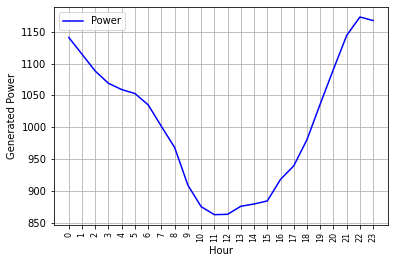

In [ ]:
## Hourly trend
result_hourly = df.groupby(['Hour']).mean()

hours = [hour for hour, df in df.groupby('Hour')]
plt.plot(hours, result_hourly['Power (kW)'], color = 'blue', label = 'Power')
plt.xlabel('Hour')
plt.ylabel('Generated Power')
plt.xticks(hours, rotation = 'vertical', size = 8)
plt.grid()
plt.legend()
plt.show()

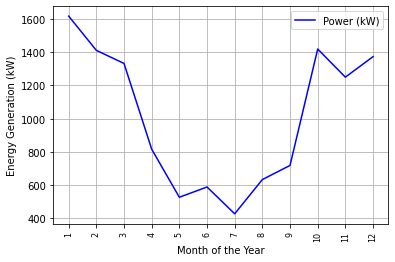

In [ ]:
## Monthly Trend
months = [month for month, df in df.groupby('Month')] 

result_monthly = df.groupby('Month').mean()
plt.plot(months, result_monthly['Power (kW)'], color = 'blue', label = 'Power (kW)')
plt.xlabel('Month of the Year')
plt.ylabel('Energy Generation (kW)')
plt.xticks(months, rotation = 'vertical', size = 8)
plt.grid()
plt.legend()
plt.show()

**Monthly Interval Forecasting with SARIMA**

In [ ]:
monthly_df = df
monthly_df.set_index(monthly_df['Datetime'], inplace = True)

In [ ]:
## Reform dataframe
monthly_df = df
del monthly_df['Wind Speed']
del monthly_df['Wind Direction']
del monthly_df['Temperature']
del monthly_df['Hour']
del monthly_df['Month']
monthly_df = monthly_df.resample('M').sum()

monthly_df

,Power (kW)
Datetime,
2018-01-31,8.004892e+06
2018-02-28,3.433154e+06
2018-03-31,3.803932e+06
2018-04-30,4.513593e+06
2018-05-31,1.990420e+06
2018-06-30,1.756170e+06
2018-07-31,1.425954e+06
2018-08-31,2.588480e+06
2018-09-30,3.139435e+06


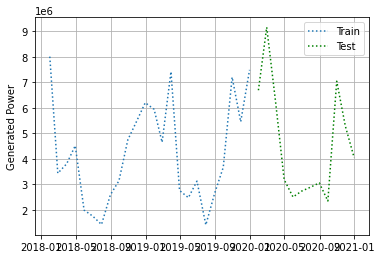

In [ ]:
## Split into training and testing sets

train_horizon = int(24) ## Use 2 years of data to predict the year

monthly_train = monthly_df[0:train_horizon]
monthly_test = monthly_df[train_horizon:] ## Renaming the test group because of the confusion after running auto arima function

plt.plot(monthly_train.index.to_pydatetime(), monthly_train, linestyle = 'dotted', label = 'Train')
plt.plot(monthly_test.index.to_pydatetime(), monthly_test, color = 'g', linestyle = 'dotted', label = 'Test')
plt.ylabel('Generated Power')
plt.grid()
plt.legend()
plt.show()

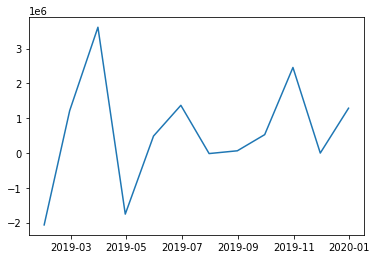

In [ ]:
## Check the appropriate number of time step for a seasonal period
sarima_preview_monthly = monthly_train.diff(12) ## The trend repeats yearly, so period is 12

plt.plot(sarima_preview_monthly)

In [ ]:
## Test stationarity of the data after seasonal differencing

sarima_preview_monthly = sarima_preview_monthly.dropna()
seasonal_dff_test_monthly = adfuller(sarima_preview_monthly['Power (kW)'], autolag='AIC')
print('Result from  Dickey-Fuller Test')

test_output_monthly = pd.Series(seasonal_dff_test_monthly[0:4], index = ['Test Statistics', 'p value', '# Lags used', '# Observation'])
print(test_output_monthly)

if test_output_monthly[1] <= 0.05:
    print('Reject null hypothesis, the data is stationary')
else:
    print('Null hypothesis is not rejected, the data is not stationary')

Result from  Dickey-Fuller Test
Test Statistics    -4.895239
p value             0.000036
# Lags used         0.000000
# Observation      11.000000
dtype: float64
Reject null hypothesis, the data is stationary


In [ ]:
## Test stationarity of the training data
monthly_train_test = adfuller(monthly_train['Power (kW)'], autolag='AIC')
print('Result from  Dickey-Fuller Test')

monthly_train_test_output = pd.Series(monthly_train_test[0:4], index = ['Test Statistics', 'p value', '# Lags used', '# Observation'])
print(monthly_train_test_output)

if monthly_train_test_output[1] <= 0.05:
    print('Reject null hypothesis, the data is stationary')
else:
    print('Null hypothesis is not rejected, the data is not stationary')

Result from  Dickey-Fuller Test
Test Statistics    -3.969594
p value             0.001578
# Lags used         5.000000
# Observation      18.000000
dtype: float64
Reject null hypothesis, the data is stationary


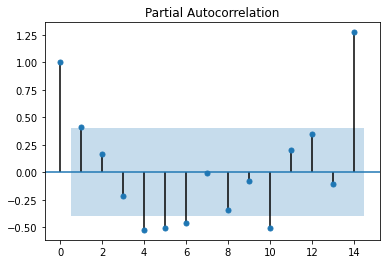

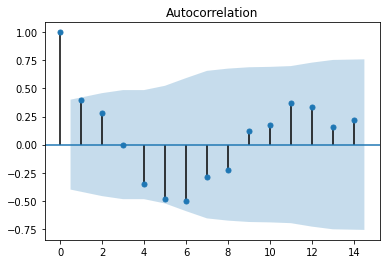

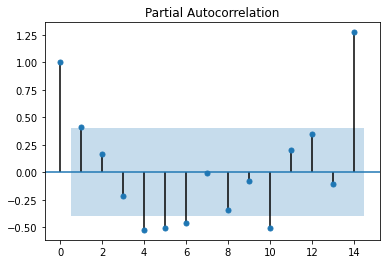

In [ ]:
## Plot to identify p, q parameters
plot_acf(monthly_train)
plot_pacf(monthly_train)

p=1, d=0, q=0

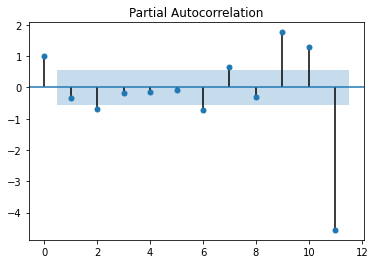

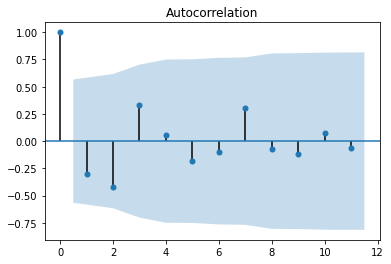

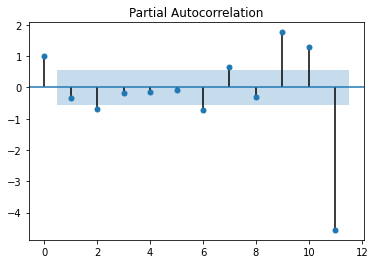

In [ ]:
## Identify P,D,Q Seasonal parameters
plot_acf(sarima_preview_monthly)
plot_pacf(sarima_preview_monthly)

P=0, D=0, Q

In [ ]:
## Build model 
sarima_mod_monthly = sm.tsa.statespace.SARIMAX(monthly_train['Power (kW)'], order=(1,0,0), seasonal_order=(0,0,0,12)) 
sarima_result_monthly = sarima_mod_monthly.fit()
sarima_result_monthly.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:             Power (kW)   No. Observations:                   24
Model:               SARIMAX(1, 0, 0)   Log Likelihood                -383.013
Date:                Wed, 03 Mar 2021   AIC                            770.025
Time:                        14:49:31   BIC                            772.381
Sample:                    01-31-2018   HQIC                           770.650
                         - 12-31-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9492      0.061     15.605      0.000       0.830       1.068
sigma2      3.695e+12   1.49e-15   2.49e+27      0.000    3.69e+12    3.69e+12
===================================================================================
Ljung-Box (Q):                         nan   Jarque-Bera (JB):                 2.12
Prob(Q):                               nan   Prob(JB):                         0.35
Heteroskedasticity (H):               0.86   Skew:                            -0.71
Prob(H) (two-sided):                  0.83   Kurtosis:                         3.30
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 1.25e+43. Standard errors may be unstable.
"""

2135927.763067196


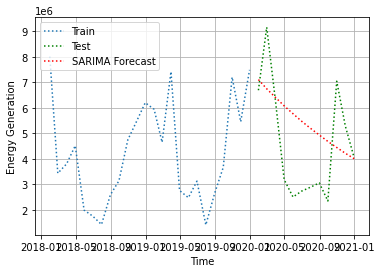

In [ ]:
## Evaluating the model by comparing predicted values and test dataset

sarima_forecast_monthly = sarima_result_monthly.predict(train_horizon, len(monthly_df)-1, typ = 'levels', dynamic = False) ## Predict for the same period of test dataset

sarima_mse_monthly = mean_squared_error(monthly_test, sarima_forecast_monthly)
sarima_rmse_monthly = sqrt(sarima_mse_monthly)
#model_comparison = list()
#model_comparison.append(['SARIMA Weekly', sarima_mse_w])
print(sarima_rmse_monthly)
plt.plot(monthly_train.index.to_pydatetime(), monthly_train, label ='Train', linestyle = 'dotted')
plt.plot(monthly_test.index.to_pydatetime(), monthly_test, label = 'Test', color = 'g', linestyle = 'dotted')
plt.plot(sarima_forecast_monthly.index.to_pydatetime(), sarima_forecast_monthly, label = 'SARIMA Forecast', color = 'r', linestyle = 'dotted')
plt.legend()
plt.xlabel('Time')
plt.ylabel('Energy Generation')
plt.grid()
plt.show()

In [ ]:
## Rolling prediction for SARIMA
def rolling_forecast_function_sarima(train_set, test_set, p, d, q, P, D, Q, m, y_label):
    rolling_sarima_predictions = list()
    for train_end in test_set.index:
        train_data = df[:train_end-datetime.timedelta(days=1)]
        rolling_model_sarima = sm.tsa.statespace.SARIMAX(train_set, order=(p,d,q), seasonal_order=(P,D,Q,m)) 
        rolling_model_sarima_fit = rolling_model_sarima.fit()
        rolling_sarima_pred = rolling_model_sarima_fit.forecast()
        rolling_sarima_yhat = rolling_sarima_pred[0]
        rolling_sarima_predictions.append(rolling_sarima_yhat)
    rolling_sarima_predictions = pd.Series(rolling_sarima_predictions, index = test_set.index)
    #fig, ax1 = plt.subplots()
    #ax2 = ax1.twiny()
    #ax1.plot(test_group, linestyle = 'dotted', color = 'green', label = 'Test Data') ## plot 1 
    #ax2.plot(rolling_sarima_predictions, linestyle = '-', color = 'red', label = 'Rolling Prediction') ## plot 2
    #ax1.set_xlabel('Time Series')
    #ax1.set_ylabel(y_label)
    plt.plot(rolling_sarima_predictions.index.to_pydatetime(), rolling_sarima_predictions, color = 'red', label = 'SARIMA Rolling Prediction')
    plt.plot(test_set.index.to_pydatetime(),test_set, color = 'green', linestyle ='dotted', label = 'Test')
    plt.ylabel(y_label)
    plt.legend()
    plt.grid()
    plt.show()
    rolling_sarima_predictions = np.nan_to_num(rolling_sarima_predictions)
    check_element = 0
    if check_element in rolling_sarima_predictions:
        print('NaN value exist in prediction, can not calculate RMSE')
        rolling_sarima_mse = float('nan')
    else:
        rolling_sarima_mse = mean_squared_error(test_set, rolling_sarima_predictions)
        print('RMSE for Rolling Prediction:', rolling_sarima_mse)
        return rolling_sarima_mse
    return rolling_sarima_mse

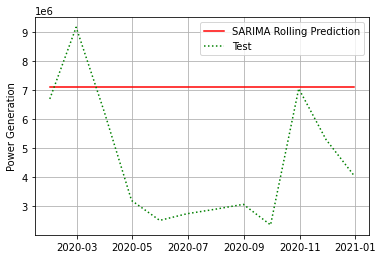

RMSE for Rolling Prediction: 10857668188424.91


10857668188424.91

In [ ]:
rolling_forecast_function_sarima(monthly_train, monthly_test, 1, 0, 0, 0, 0, 0, 12, 'Power Generation')

**Short Term Forecasting with 10-min interval**

In [ ]:
## Form new dataframe with total of 1 month of data
short_start = 92*24*6 ## Use data from October to train the model
short_end = 61*24*6 
short_df = df[len(df) - short_start: len(df) - short_end]
short_df.set_index(short_df['Datetime'], inplace = True)
del short_df['Wind Speed']
del short_df['Wind Direction']
del short_df['Temperature']
del short_df['Datetime']
short_df

,Power (kW)
Datetime,
2020-10-01 00:00:00,1257.0
2020-10-01 00:10:00,1505.0
2020-10-01 00:20:00,1589.0
2020-10-01 00:30:00,1623.0
2020-10-01 00:40:00,1600.0
...,...
2020-10-31 23:10:00,2975.0
2020-10-31 23:20:00,2643.0
2020-10-31 23:30:00,2467.0


In [ ]:
## Seperate into training and testing sets
testing_interval = 7 * 24 * 6 # predict for 7 days
train_size = int(len(short_df) - testing_interval) ## Use the first 28 (29) days as training set

train_short = short_df[0:train_size]
test_short = short_df[train_size:] ## Renaming the test group because of the confusion after running auto arima function

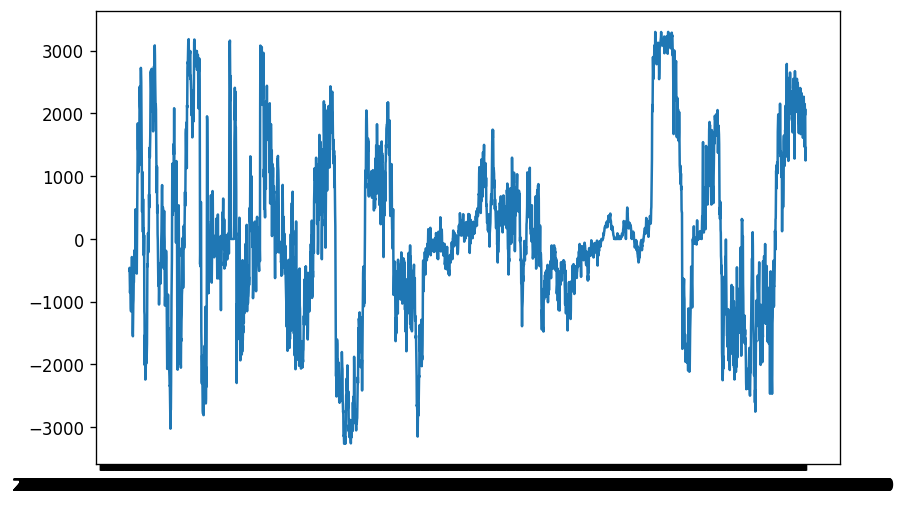

In [ ]:
## Check the appropriate number of time step for a seasonal period
sarima_preview_short = train_short['Power (kW)'].diff(144) ## As the trend repeats daily, the sesonal period is every 24 hours

plt.plot(sarima_preview_short)

In [ ]:
## Test stationarity of the data after seasonal differencing

sarima_preview_short = sarima_preview_short.dropna()
seasonal_dff_test_short = adfuller(sarima_preview_short, autolag='AIC')
print('Result from  Dickey-Fuller Test')

test_output_short = pd.Series(seasonal_dff_test_short[0:4], index = ['Test Statistics', 'p value', '# Lags used', '# Observation'])
print(test_output_short)

if test_output_short[1] <= 0.05:
    print('Reject null hypothesis, the data is stationary')
else:
    print('Null hypothesis is not rejected, the data is not stationary')

Result from  Dickey-Fuller Test
Test Statistics   -5.806229e+00
p value            4.509864e-07
# Lags used        9.000000e+00
# Observation      3.302000e+03
dtype: float64
Reject null hypothesis, the data is stationary


In [ ]:
## Test stationarity of the training data

seasonal_dff_test_train_short = adfuller(train_short['Power (kW)'], autolag='AIC')
print('Result from  Dickey-Fuller Test')

test_output_train_short = pd.Series(seasonal_dff_test_train_short[0:4], index = ['Test Statistics', 'p value', '# Lags used', '# Observation'])
print(test_output_train_short)

if test_output_train_short[1] <= 0.05:
    print('Reject null hypothesis, the data is stationary')
else:
    print('Null hypothesis is not rejected, the data is not stationary')

Result from  Dickey-Fuller Test
Test Statistics      -4.818412
p value               0.000050
# Lags used           3.000000
# Observation      3452.000000
dtype: float64
Reject null hypothesis, the data is stationary


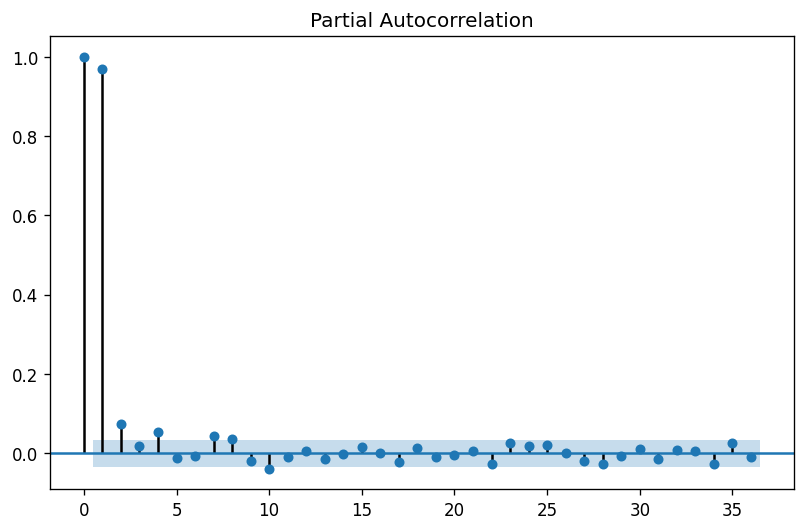

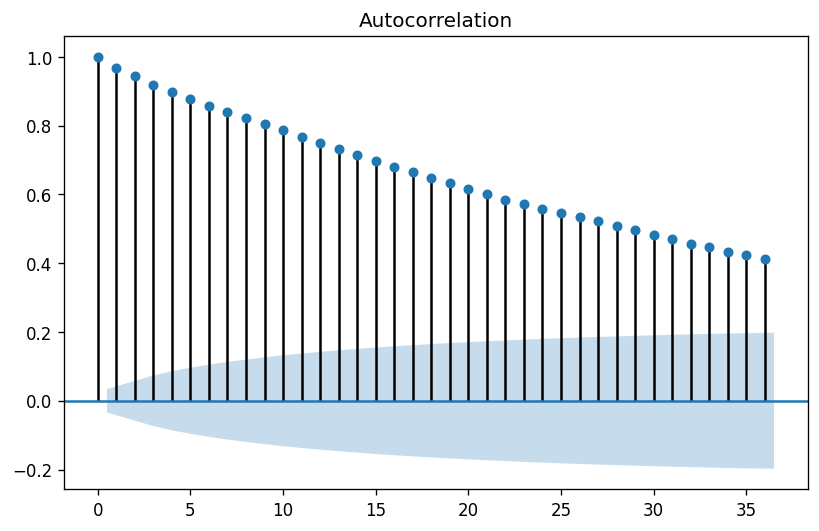

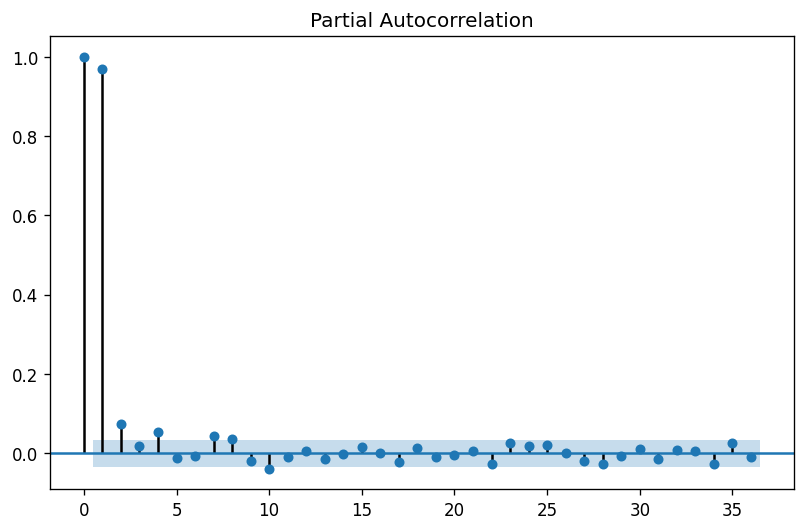

In [ ]:
## Plot the ACF and PACF to identify seasonal parameters 

plot_acf(sarima_preview_short)
plot_pacf(sarima_preview_short)

P = 2, D = 1, Q = 0, m = 144

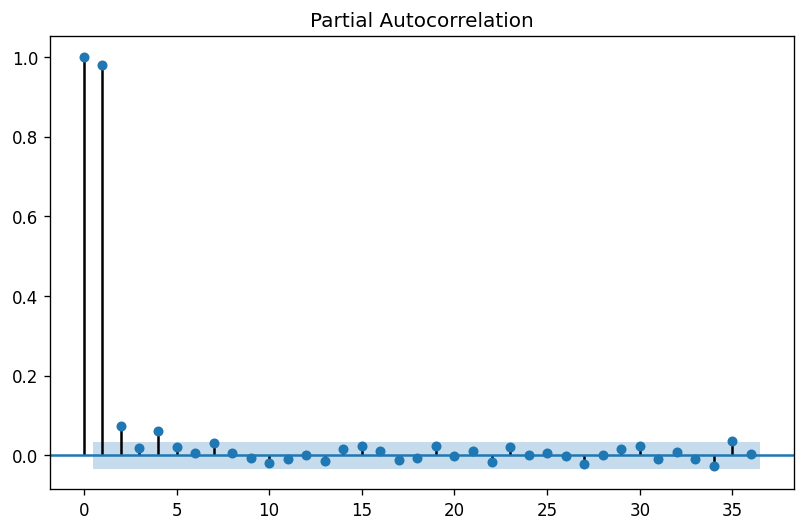

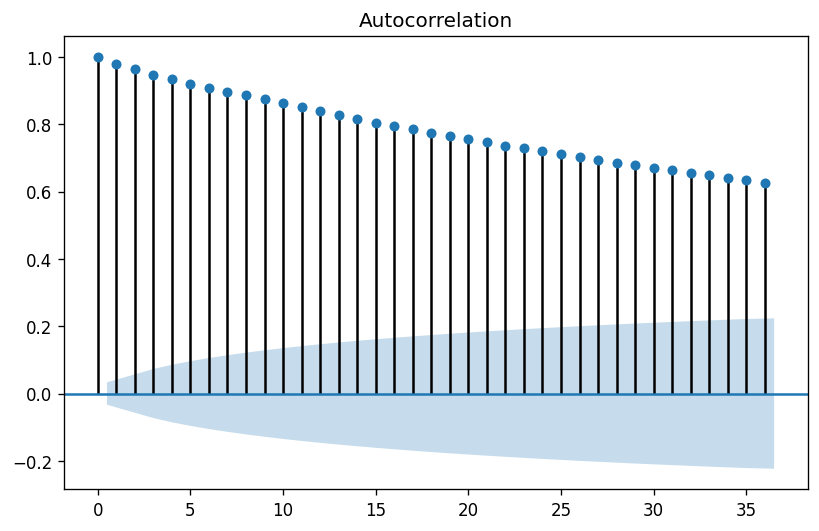

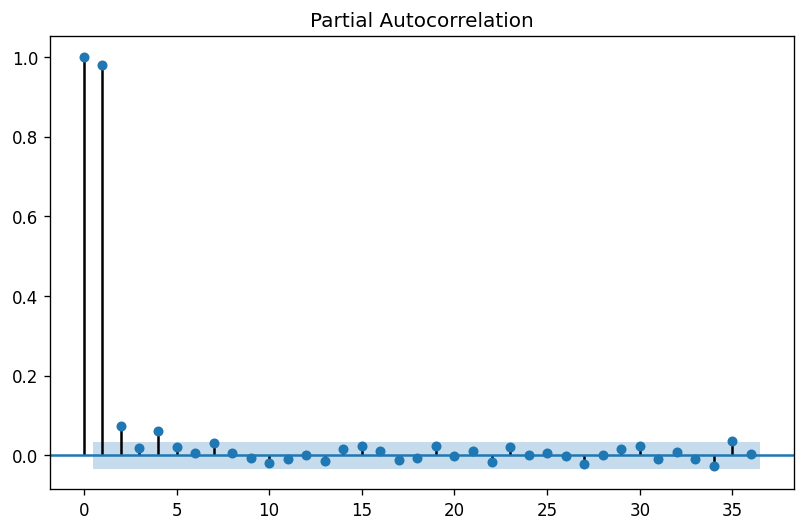

In [ ]:
## Plot training data to idenfiy p, d, q
plot_acf(train_short)
plot_pacf(train_short)

p = 2, d = 0, q = 0

In [ ]:
## Fit model with the parameters identified from graphs
sarima_mod_short = sm.tsa.statespace.SARIMAX(train_short['Power (kW)'], order=(2,0,0), seasonal_order=(2,1,0,144)) 
sarima_result_short = sarima_mod_short.fit()
sarima_result_short.summary()